In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
pd.options.mode.chained_assignment = None  # default='warn'
from scipy.spatial import distance as dist
import scipy.cluster.hierarchy as hier
import os
import numpy as np

file_path = './test_files/3Dblood27.11.txt'
df = pd.read_csv(file_path, header=None)
df.columns = ['x', 'y', 'z', 'r', 'g', 'b']
df

,x,y,z,r,g,b
0,4.300000,11.197390,3.047941,0,0,0
1,4.200000,11.197390,3.047941,0,0,0
2,4.100000,11.197390,3.047941,0,0,0
3,4.000000,11.197390,3.047941,0,0,0
4,3.900000,11.197390,3.047941,0,0,0
...,...,...,...,...,...,...
1799,4.324351,10.356519,3.886832,255,0,255
1800,4.253031,10.706822,3.538061,255,0,255
1801,4.260648,10.636221,3.608462,255,0,255
1802,4.295052,11.128907,3.116422,255,0,255


In [ ]:
def distance_calculator(df):
    dx = df['x'].diff()
    dy = df['y'].diff()
    dz = df['z'].diff()

    # Calculate the Euclidean distance between consecutive rows
    distances = np.sqrt(dx**2 + dy**2 + dz**2)
    df['distance_from_last'] = distances
    return df

def remove_overlap(shape):
    # Checks for any large jumps at the end of a line and, if found, moves the last row to the top
    # This hopefully removes the jump and makes the line continuous
    # Note this seems very fragile and I probably need add a second check for large jumps at the end of the code
    if shape.iloc[-1]['distance_from_last'] > 2.:
        # Move the last row to the top
        last_row = shape.iloc[[-1]]  # Select the last row as a DataFrame
        remaining_rows = shape.iloc[:-1]  # Select all rows except the last
        shape = pd.concat([last_row, remaining_rows]).reset_index(drop=True)

    shape = distance_calculator(shape)
    return shape

def midlinejumpsplitter(shape):
    # This needs generalising to lines with more than 2 jumps
    id = shape['line_id'].unique()[0]
    # Split the line at the index - at the moment uses a completely arbitrary distance of 2mm
    split_index = shape[shape['distance_from_last'] > 2.].index[0]
    shape1 = shape.iloc[:split_index]
    shape1['line_id'] = 1
    shape1['distance_from_last'].iloc[0] = np.nan
    shape2 = shape.iloc[split_index:]
    shape2['line_id'] = 2
    shape2['distance_from_last'].iloc[0] = np.nan
    return shape1, shape2

def shapesplitter(df):
    # Identify line IDs that have large jumps in the middle
    line_ids = np.sort(df['line_id'].unique())   # Sorting makes life easier later
    line_ids_new = line_ids.copy()   # A list of line IDs that we're going to update
    for line_id in line_ids:
        shape = df[df['line_id'] == line_id]
        if shape['distance_from_last'].max() > 2.:
            shape1, shape2 = midlinejumpsplitter(shape)
            df  = df[df['line_id'] != line_id] 
            line_ids_new = line_ids_new[line_ids_new != line_id]
            line_ids_new = np.append(line_ids_new, [line_ids_new[-1]+1, line_ids_new[-1]+2])
            shape1['line_id'], shape2['line_id'] = line_ids_new[-2], line_ids_new[-1]
            shape = pd.concat([shape1, shape2])
            df = pd.concat([df, shape])  
    return df

def node_finder(df):
    # Use hierarchical clustering to note common start / end points
    # Calculate node positions based on cluster centroids
    # Append centroids to start / end of each line
    start_points = df.groupby('line_id').first() # First point of each line
    end_points = df.groupby('line_id').last() # Last
    terminal_points = pd.concat([start_points, end_points])   # Combine the two
    dist_mat = dist.pdist(terminal_points[['x', 'y', 'z']].values)   
    link_mat = hier.linkage(dist_mat)
    # fcluster assigns each of the particles in positions a cluster to which it belongs
    cluster_idx = hier.fcluster(link_mat, t=1, criterion='distance')   # t defines the max cophonetic distance in a cluster
    terminal_points['cluster'] = cluster_idx

    # Calculate the mean position of each cluster
    nodes = terminal_points.groupby('cluster').mean()
    for n in terminal_points.index.unique():
        clusters = terminal_points.loc[n]['cluster']
        for c in clusters:
            new_point = nodes.loc[c:c]
            line = df[df['line_id'] == n]
            line_start = line.head(1)
            line_end = line.tail(1)
            new_point[['r', 'g', 'b', 'line_id']] = line_start[['r', 'g', 'b', 'line_id']].values

            start_sep = dist.euclidean(new_point[['x', 'y', 'z']].values[0], line_start[['x', 'y', 'z']].values[0])
            end_sep = dist.euclidean(new_point[['x', 'y', 'z']].values[0], line_end[['x', 'y', 'z']].values[0])
            if start_sep < end_sep:
                line = pd.concat([new_point, line]) 
            elif start_sep > end_sep:
                line = pd.concat([line, new_point])
            
            df = df[df['line_id'] != n]
            df = pd.concat([df, line])
            df = df.reset_index(drop=True)
            df = distance_calculator(df)
            
            # Set distance from last to NaN for the first row of each line
            df.loc[df.groupby('line_id').head(1).index, 'distance_from_last'] = np.nan
    return df, terminal_points, nodes

def line_plotter(df):
    # Plots lines assigning a colour to each line_id
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for n in np.unique(df['line_id'].values):
        ax.plot(df[df['line_id'] == n]['x'], df[df['line_id'] == n]['y'], df[df['line_id'] == n]['z'])

    # If you need a specific line plotting
    # n = 2
    # ax.plot(df[df['line_id'] == n]['x'], df[df['line_id'] == n]['y'], df[df['line_id'] == n]['z']

    for n in np.unique(terminal_points['cluster'].values):
        ax.scatter(terminal_points[terminal_points['cluster'] == n]['x'], terminal_points[terminal_points['cluster'] == n]['y'], terminal_points[terminal_points['cluster'] == n]['z'])

    ax.view_init(elev=30, azim=60)  # Elevation of 30 degrees, azimuth of 45 degrees
    plt.show()


def eulerficator(df, terminal_points, nodes):
    terminal_points_nogroups = terminal_points.reset_index()
    clusters = terminal_points_nogroups['cluster'].unique()
    lines = terminal_points_nogroups['line_id'].unique()

    # Run through each cluster and create two dictionaries 
    # 1 - cluster numbers as key and the connecting lines as values
    # 2 - cluster numbers as key and the number of connecting nodes as values
    cluster_dict = {}
    connectivity_dict = {}
    for c in clusters:
        connecting_lines = terminal_points_nogroups[terminal_points_nogroups['cluster'] == c]
        cluster_dict[c] = list(connecting_lines['line_id'].values)

        connectivity_dict[c] = len(connecting_lines)

    line_order = []
    line_order_grouped = []
    node_order = [] 
    node_order_grouped = []
    while len(line_order) < len(lines):
        current_line_lines = []
        current_line_nodes = []

        # Sort lines by height order - bottom up
        min_z = df.groupby('line_id')['z'].min()
        heightsorted_line_ids = min_z.sort_values().index.tolist()
        unprinted_lines = [n for n in heightsorted_line_ids if n not in line_order]

        # Pick the unprinted line with the lowest z-value to start with
        next_line = unprinted_lines[0]
        line_order.append(next_line)
        current_line_lines.append(next_line)
        unprinted_lines = unprinted_lines[1:] # Remove the printed line from the list of remaining lines

        # Calculate which node you're at - it's the other node to which next_line is connected
        connected_nodes = terminal_points.loc[next_line]['cluster'].values

        # Start at node with lower z-value - record as first node of this line
        start_node = nodes.loc[connected_nodes]['z'].idxmin()
        current_line_nodes.append(start_node)
        node_order.append(start_node)

        # Find node at other end of line
        end_node = connected_nodes[connected_nodes != start_node][0]
        current_line_nodes.append(end_node)
        node_order.append(end_node)

        connected_lines = cluster_dict[end_node]   # Lines connected to end node
        connected_lines = [n for n in unprinted_lines if n in connected_lines]   # List unprinted connected lines in height-order
        while len(connected_lines) > 0:
            # Pick next line based on lowest z_min
            next_line = connected_lines[0]
            line_order.append(next_line)
            current_line_lines.append(next_line)
            unprinted_lines.remove(next_line)

            # Calculate which node you've moved to
            connected_nodes = terminal_points.loc[next_line]['cluster'].values
            start_node = end_node
            end_node = connected_nodes[connected_nodes != start_node][0]
            current_line_nodes.append(end_node)
            node_order.append(end_node)

            connected_lines = cluster_dict[end_node]

            # Remove lines that have already been printed
            connected_lines = [n for n in unprinted_lines if n in connected_lines]
        
        line_order_grouped.append(current_line_lines)
        node_order_grouped.append(current_line_nodes)

    return line_order, node_order, line_order_grouped, node_order_grouped


def line_order_corrector(df, line_order, line_order_grouped):
    # Make lines run in node order.
    df = df.set_index('line_id').loc[line_order].reset_index()   # Reorder the dataframe based on the line order

    for idx_path, path in enumerate(line_order_grouped):
        for idx_line, line in enumerate(path):
            start_node = node_order_grouped[idx_path][idx_line]
            line_start = df[df['line_id'] == line].iloc[0][['x', 'y', 'z']].values 
            node_loc = nodes.loc[start_node][['x', 'y', 'z']].values

            if not np.array_equal(line_start, node_loc):
                # print('Reversing line ', line)
                df[df['line_id'] == line] = df[df['line_id'] == line].iloc[::-1]
    return df

def e_calculator(df):
    alpha = 1
    diameter = 1
    df['E'] = np.pi*alpha*df['distance_from_last']*(diameter/2)**2  # Amount to extrude
    return df

# Calculate the distance between consecutive points
df = distance_calculator(df)
# If line ID column doesn't exist, assign line IDs based on RGB values
if 'line_id' not in df.columns:
    df['line_id'] = pd.factorize(df[['r','g','b']].apply(tuple, axis=1))[0]
# Remove large jumps at the end of lines
df = df.groupby('line_id', group_keys=False).apply(remove_overlap)

# Recalculate the distance between consecutive points
df = distance_calculator(df)

# Set distance from last to NaN for the first row of each line
df.loc[df.groupby('line_id').head(1).index, 'distance_from_last'] = np.nan

# Find and split lines that have big jumps in the middle, e.g., inlet and outlet lines
df = shapesplitter(df)

# Set distance from last to NaN for the first row of each line
df.loc[df.groupby('line_id').head(1).index, 'distance_from_last'] = np.nan

# Find nodes using hierarchical clustering
df, terminal_points, nodes = node_finder(df)

# Calculate line order via z-weighted Fleury-ish algorithm
line_order, node_order, line_order_grouped, node_order_grouped = eulerficator(df, terminal_points, nodes)

# Correct line order to run in node order
df = line_order_corrector(df, line_order, line_order_grouped)
df = distance_calculator(df)
df = df[df['distance_from_last'] != 0.]

# Calculate extrusion amount between points
df = e_calculator(df)

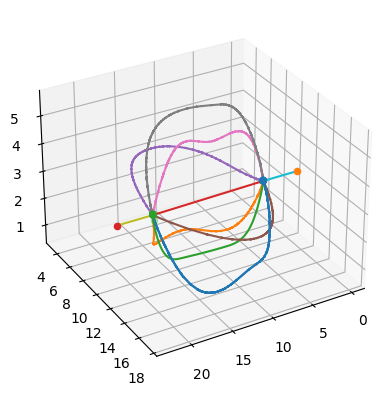

In [8]:
# Plots lines assigning a colour to each line_id    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for n in line_order:
    ax.plot(df[df['line_id'] == n]['x'], df[df['line_id'] == n]['y'], df[df['line_id'] == n]['z'])  

# for n in np.unique(df['line_id'].values):
#     ax.plot(df[df['line_id'] == n]['x'], df[df['line_id'] == n]['y'], df[df['line_id'] == n]['z'])

# If you need a specific line plotting
n = 2
ax.plot(df[df['line_id'] == n]['x'], df[df['line_id'] == n]['y'], df[df['line_id'] == n]['z'])

for n in np.unique(terminal_points['cluster'].values):
    ax.scatter(terminal_points[terminal_points['cluster'] == n]['x'], terminal_points[terminal_points['cluster'] == n]['y'], terminal_points[terminal_points['cluster'] == n]['z'])

ax.view_init(elev=30, azim=60)  # Elevation of 30 degrees, azimuth of 45 degrees
plt.show()

In [ ]:
# Something weird happening with how we rearrange the start/end of lines to match the nodes
for n in line_order:
    print(df[df['line_id'] == n].head(1))

   line_id          x          y         z  r    g  b  distance_from_last   E
0        2  18.111437  11.205359  2.967406  0  127  0                 NaN NaN
     line_id          x          y         z  r    g    b  distance_from_last  \
207        3  18.111437  11.205359  2.967406  0  255  255           13.779254   

             E  
207  10.822201  
     line_id          x          y         z  r    g  b  distance_from_last  \
411        1  18.111437  11.205359  2.967406  0  255  0           13.779254   

             E  
411  10.822201  
     line_id          x          y         z    r  g  b  distance_from_last  \
569        4  18.111437  11.205359  2.967406  255  0  0           13.779254   

             E  
569  10.822201  
     line_id          x          y         z    r    g  b  distance_from_last  \
849        5  18.111437  11.205359  2.967406  255  255  0           13.779254   

             E  
849  10.822201  
      line_id          x          y         z    r    g  b  \
11

In [ ]:
alpha = 1
diameter = 1
df['E'] = np.pi*alpha*df['distance_from_last']*(diameter/2)**2  # Amount to extrude

path = line_order_grouped[0]
df_write = df.set_index('line_id').loc[line_order].reset_index()   # Reorder the dataframe based on the line order
for line in path:
    # Prep output for writing
    gcode_output = "\n".join(
        "G01 X" + df[].astype(str) + " Y" + df["y_coord"].astype(str)
    )

    # Write to a file
    with open("gcode.txt", "w") as file:
        file.write(gcode_output)


In [3]:
df[df['line_id'] == 1]

,line_id,x,y,z,r,g,b,distance_from_last,E
408,1,18.111596,11.182686,2.986609,0,255,0,NaN,NaN
409,1,18.173898,11.206091,2.920448,0,255,0,0.093844,0.073705
410,1,18.130112,11.205503,2.830550,0,255,0,0.099996,0.078537
411,1,18.083607,11.204930,2.742028,0,255,0,0.099996,0.078537
412,1,18.034410,11.204372,2.654973,0,255,0,0.099996,0.078537
...,...,...,...,...,...,...,...,...,...
559,1,4.466900,11.197392,2.798698,0,255,0,0.099999,0.078539
560,1,4.409750,11.197391,2.880757,0,255,0,0.099999,0.078539
561,1,4.354116,11.197391,2.963851,0,255,0,0.099999,0.078539
562,1,4.300000,11.197390,3.047941,0,255,0,0.099999,0.078539


In [ ]:
# Filter and reorder
df_write = (
    df[df["line_id"].isin(line_order_grouped[0])]  # Select rows with IDs in desired_order
    .set_index("line_id")                 # Set ID as the index
    .loc[line_order_grouped[0]]              # Reorder based on desired_order
    .reset_index()                   # Reset the index
)



,x,y,z,r,g,b,distance_from_last
cluster,,,,,,,
1,4.336544,11.183789,3.057216,113.333333,113.222222,85.0,0.094117
2,0.000000,11.197390,3.047941,0.000000,0.000000,0.0,0.000000
3,18.111596,11.182686,2.986609,113.333333,113.222222,85.0,0.165535
4,22.500492,11.206475,2.978680,0.000000,0.000000,0.0,0.000000
